In [1]:
import os
import numpy as np
import cv2
import mediapy as media
import itertools as it

In [2]:
folder = 'parrington'
name = 'prtn'

In [338]:
img_name = [i for i in os.listdir(folder) if name in i]
indices = np.argsort([int(i.split('.')[0][-2:]) for i in img_name])
img_name = np.array(img_name)[indices]
imgs = np.array([media.read_image(f"{folder}/{i}").astype(np.float32)/255 for i in img_name])

gimgs = np.array([cv2.cvtColor(i, cv2.COLOR_BGR2GRAY) for i in  imgs])

## DoG in Scale-Space

In [339]:
SIGMA = 1.6
S = 4
mult = 2**(1/(S-1))
OCTAVE = 5
img = gimgs[0]

In [346]:
kernels = []
# sigs = []
for o in range(OCTAVE):
    sigma = SIGMA * (2**o)
    for s in range(S):
        # print(sigma)
        kernels.append(cv2.getGaussianKernel(3, sigma, cv2.CV_32F))
        # sigs.append(sigma)
        sigma *= mult
k_gs = np.array(kernels) # (S*OCTAVE, 3, 1)
k_gs = np.matmul(k_gs, k_gs.transpose(0, 2, 1)).reshape(OCTAVE, S, 3, 3)
k_dog = np.diff(k_gs, axis=1)
# sigs = np.array(sigs).reshape(OCTAVE, S).astype(np.float32)

In [347]:
# norm = lambda x: (x-x.min()) / (x.max()-x.min())
def normalize(img):
    min = img.min()
    ret = img.copy() - min
    ret /= ret.max()
    return ret

scale_imgs = []
tar = cv2.GaussianBlur(img, (3, 3), SIGMA)
for o in range(OCTAVE):
    scale_imgs.append(
        [normalize(cv2.filter2D(tar, cv2.CV_32F, k_dog[o, s])) for s in range(S-1)]
        # [(cv2.filter2D(tar, cv2.CV_32F, k_dog[o, s])) for s in range(S-1)]
    )
    tar = cv2.resize(tar, (tar.shape[1]//2, tar.shape[0]//2))

,,

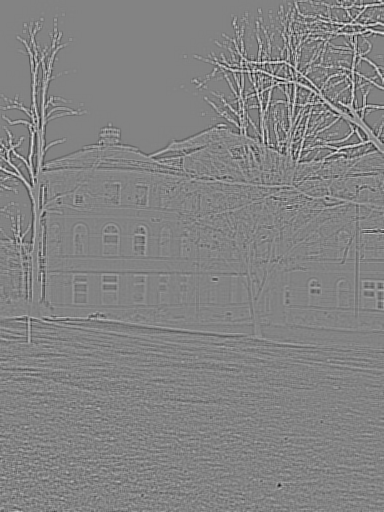
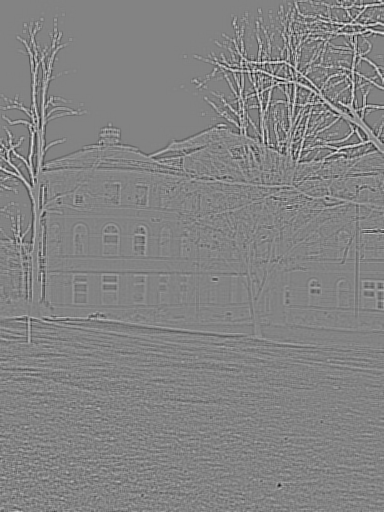
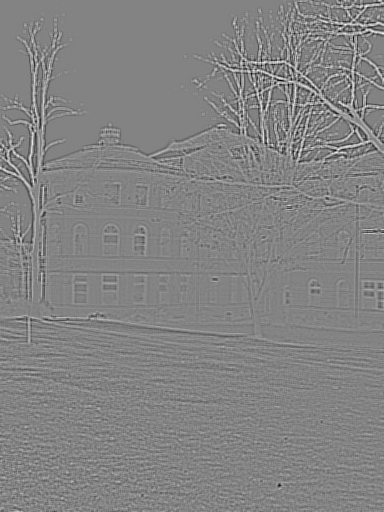

,,

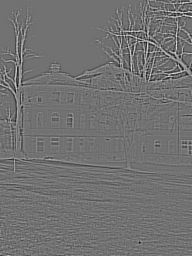
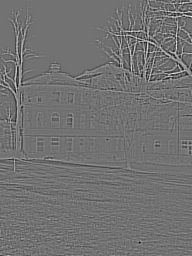
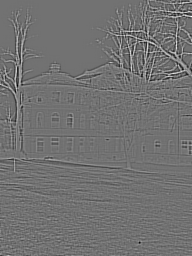

,,

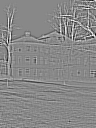
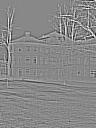
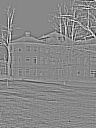

,,

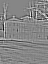
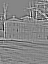
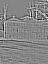

,,


In [348]:
for i in range(OCTAVE):
    media.show_images(scale_imgs[i])

## Key Localization (extrema)

In [371]:
def computeGradient(blk):
    dx = 0.5*(blk[:, 2, 1, 1] - blk[:, 0, 1, 1])
    dy = 0.5*(blk[:, 1, 2, 1] - blk[:, 1, 0, 1])
    dz = 0.5*(blk[:, 1, 1, 2] - blk[:, 1, 1, 0])
    grad = np.transpose([dx, dy, dz], (1, 0))
    return grad

def computeHessian(blk):
    pix = blk[:, 1, 1, 1]
    dxx = blk[:, 2, 1, 1] - 2 * pix + blk[:, 0, 1, 1]
    dyy = blk[:, 1, 2, 1] - 2 * pix + blk[:, 1, 0, 1]
    dzz = blk[:, 1, 1, 2] - 2 * pix + blk[:, 1, 1, 0]
    dxy = 0.25 * (blk[:, 2, 2, 1] - blk[:, 2, 0, 1] - blk[:, 0, 2, 1] + blk[:, 0, 0, 1])
    dxz = 0.25 * (blk[:, 2, 1, 2] - blk[:, 2, 1, 0] - blk[:, 0, 1, 2] + blk[:, 0, 1, 0])
    dyz = 0.25 * (blk[:, 1, 2, 2] - blk[:, 1, 2, 0] - blk[:, 1, 0, 2] + blk[:, 1, 0, 0])
    hess = np.array([
        [dxx, dxy, dxz], 
        [dxy, dyy, dyz],
        [dxz, dyz, dzz]]).transpose(2, 0, 1)
    return hess

In [491]:
def detectExterema(simgs, threshold=0.3):
    simgs = np.array(simgs)
    h, w = simgs[0].shape
    slwds = np.lib.stride_tricks.sliding_window_view(simgs, (3, 3, 3))
    ids = []
    for idx_img, slwd in enumerate(slwds):
        slwd_flat = slwd.reshape(*slwd.shape[:2], -1)
        # (1, 1, 1) == np.unravel_index(13, (3, 3, 3))
        # That is, the center has index 13 in a 3x3x3 block
        select = slwd_flat.argmax(2) == 13

        # print(slwd.shape)
        # print(maxs.shape)
        # (..., scale, h, w)
        blk = slwd[select]
        # print(blk.shape)
        
        # Gradient
        grad = computeGradient(blk)
        # print(grad.shape)
        
        # Hessian
        hess = computeHessian(blk)
        # print(hess.shape)

        # Fix exterema position
        idx_fixed = -np.matmul(np.linalg.inv(hess), grad.reshape(grad.shape[0], 3, 1)).squeeze()
        idx_fix_orig = idx_fixed.copy()

        sel_pos = idx_fixed>.5
        sel_neg = idx_fixed<-.5
        idx_fixed[sel_pos] = 1
        idx_fixed[sel_neg] = -1
        idx_fixed[~(sel_pos|sel_neg)] = 0
        idx_fixed = idx_fixed.astype(int)
        
        idx = np.argwhere(select)+1
        idx_fixed += np.concatenate([np.ones((len(idx), 1)), idx], 1).astype(int)
        
        # Remove low contrast
        val = simgs[idx_img:idx_img+3][tuple(zip(*idx_fixed))] + 0.5*(grad*idx_fix_orig).sum(1)
        sel_low = val > 0.03

        # Remove edges
        H = hess[:, 1:, 1:]
        tr = np.trace(H, axis1=1, axis2=2)
        det = np.linalg.det(H)
        sel_edge = (tr**2 / det) < 12.1
        select = (sel_edge&sel_edge)
        print(f"Remove {(~select).sum()} points")

    return idx_fixed[:, 1:][select]

In [492]:
ids = []
for o in range(OCTAVE):
    oids = np.array(detectExterema(scale_imgs[o]))
    if len(oids) == 0:
        print(f"Skip {o+1}")
        ids.append([])
        continue
    oids = np.concatenate([oids, np.full((oids.shape[0], 1), 2**o)], 1)
    ids.append(oids.tolist())
    print(f"Octave {o+1}: {len(oids)}")

Remove 0 points
Octave 1: 20
Remove 40 points
Octave 2: 283
Remove 2 points
Octave 3: 114
Remove 25 points
Octave 4: 190
Remove 7 points
Octave 5: 45


""

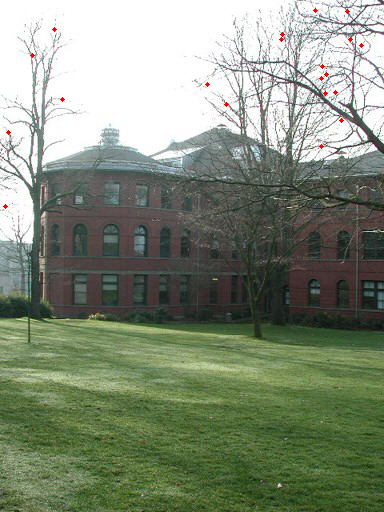

""

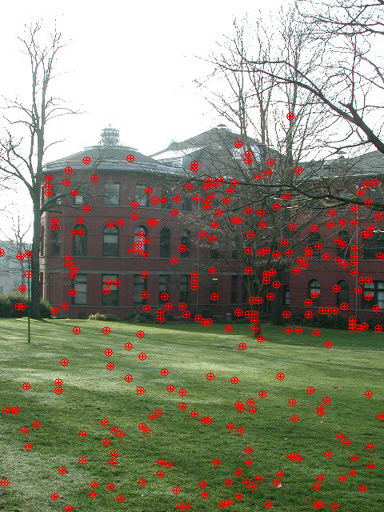

""

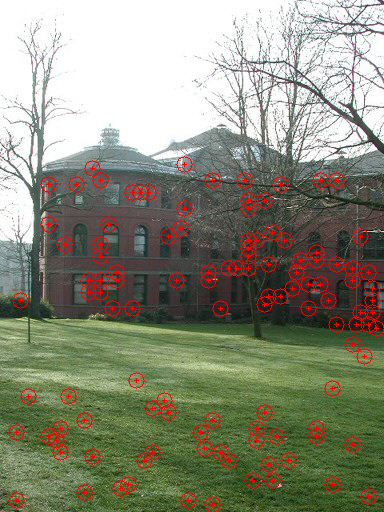

""

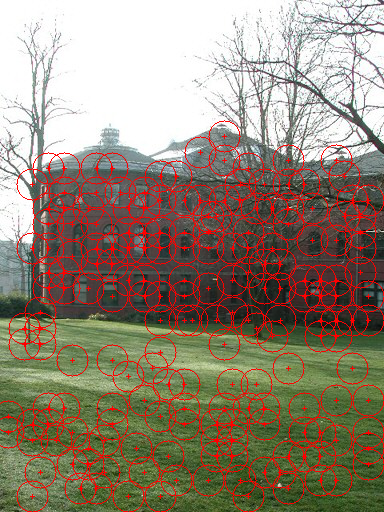

""

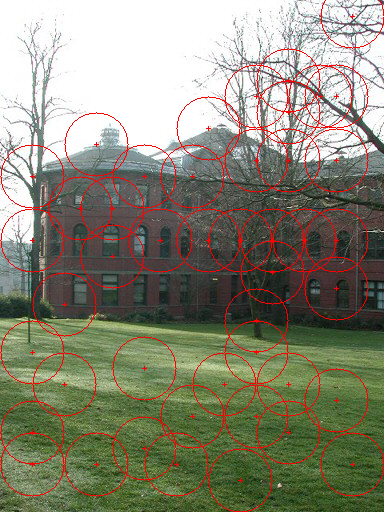

In [493]:
for o in range(OCTAVE):
    p = imgs[0].copy()
    id = ids[o]
    if len(id) == 0:
        continue
    for i, j, s in id:
        # color = (255, 255//s ,255//s)
        color = (255, 0 ,0)
        cv2.drawMarker(p, (j*s, i*s), color, markerSize=5)
        cv2.circle(p, (j*s, i*s), int(s*2), color, 1)
    media.show_image(p)

### Location Refinement

In [26]:
for o in range(OCTAVE):
    

0.534539